In [1]:
import os
import numpy as np
import pandas as pd
import eipy.ei as e
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import pickle as pkl

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import pandas as pd
from eipy.additional_ensembles import MeanAggregation, CES
from eipy.metrics import fmax_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate
import seaborn as sns
import warnings

2024-02-08 20:45:18.120713: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 20:45:18.147577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 20:45:18.147602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 20:45:18.148311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 20:45:18.152720: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 20:45:18.153771: I tensorflow/core/platform/cpu_feature_guard.cc:1

data

In [2]:
directory = "/home/opc/block_vol/COVID-19 data"
data={}
for file_name in os.listdir(directory):
    if file_name.endswith('.csv') and not file_name.startswith('xgboost'):
        key = file_name.split('.')[0]
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)
        df = df.drop(columns=["NEW_MASKED_MRN"])
        imputer = KNNImputer(n_neighbors=5)
        df = imputer.fit_transform(df)
        data[key] = df

In [4]:
labels = pd.read_csv('/home/opc/block_vol/COVID-19 data/Basics/outcome.csv')
labels = labels["DECEASED_INDICATOR"]
labels.value_counts()

DECEASED_INDICATOR
0    3460
1    1323
Name: count, dtype: int64

dl bps

In [41]:
def build_deep_bps(input_dim):
    # Architecture 1: Simple Feedforward Neural Network
    model_1 = Sequential()
    model_1.add(Dense(64, input_dim=input_dim, activation='relu'))
    model_1.add(Dense(32, activation='relu'))
    model_1.add(Dense(1, activation='sigmoid'))
    model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Architecture 2: Deep Feedforward Neural Network with Dropout
    model_2 = Sequential()
    model_2.add(Dense(128, input_dim=input_dim, activation='relu'))
    model_2.add(Dropout(0.5))
    model_2.add(Dense(64, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(32, activation='relu'))
    model_2.add(Dense(1, activation='sigmoid'))
    model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Architecture 3: Wide and Deep Neural Network
    input_layer = Input(shape=(input_dim,))
    wide_branch = Dense(32, activation='relu')(input_layer)
    deep_branch = Dense(64, activation='relu')(input_layer)
    deep_branch = Dense(32, activation='relu')(deep_branch)
    merged = Concatenate()([wide_branch, deep_branch])
    output_layer = Dense(1, activation='sigmoid')(merged)
    model_3 = Model(inputs=input_layer, outputs=output_layer)
    model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Architecture 4: Deep Neural Network without Sequential Structure
    model_4 = Sequential()
    model_4.add(Dense(128, input_dim=input_dim, activation='relu'))
    model_4.add(Dense(64, activation='relu'))
    model_4.add(Dense(32, activation='relu'))
    model_4.add(Dense(1, activation='sigmoid'))
    model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    d_base_predictors = {"simple" : model_1,
                        # "deep_w_dropout" : model_2,
                        # "wide_n_deep" : model_3,
                        # "deeper" : model_4
                         }
    return d_base_predictors

In [42]:
base_predictors = {
                    'ADAB': AdaBoostClassifier(),
                    'XGB': XGBClassifier(),
                    # 'DT': DecisionTreeClassifier(),
                    # 'RF': RandomForestClassifier(),
                    # 'GB': GradientBoostingClassifier(),
                    # 'KNN': KNeighborsClassifier(),
                    # 'LR': LogisticRegression(),
                    # 'NB': GaussianNB(),
                    # 'MLP': MLPClassifier(),
                    # 'SVM': SVC(probability=True),
}

In [43]:
ensemble_predictors = {
                    'Mean' : MeanAggregation(),
                    'CES' : CES(scoring=lambda y_test, y_pred: fmax_score(y_test, y_pred)[0]),
                    'S.ADAB': AdaBoostClassifier(),
                    'S.XGB': XGBClassifier(),
                    'S.DT': DecisionTreeClassifier(),
                    "S.RF": RandomForestClassifier(),
                    'S.GB': GradientBoostingClassifier(),
                    'S.KNN': KNeighborsClassifier(),
                    'S.LR': LogisticRegression(),
                    'S.NB': GaussianNB(),
                    'S.MLP': MLPClassifier(),
                    'S.SVM': SVC(probability=True),
}

In [44]:
metrics = {
            'f_max': fmax_score,
            'auc': roc_auc_score,
            'mcc': matthews_corrcoef
            }

EI

In [45]:
####HI OVER HERE###
reload(e)
###HEYOOOOOO#

<module 'eipy.ei' from '/home/opc/eipy/eipy/ei.py'>

In [9]:
# performance = {k:([],[]) for k in data.keys()}
# performance["EI"] = ([],[])
# for i in range(10):
#     random_seed= i
#     X_train = {}
#     X_test = {}
#     for k, v in data.items():
#         X_train[k], X_test[k], y_train, y_test = train_test_split(v, labels, test_size=0.2, stratify=labels, random_state=i)
#     for k in data.keys():
#         EI = e.EnsembleIntegration(
#                     k_outer=5,
#                     k_inner=5,
#                     n_samples=1,
#                     sampling_strategy="undersampling",
#                     sampling_aggregation=None,
#                     n_jobs=-1,
#                     metrics=metrics,
#                     random_state=i+1,
#                     project_name="diabetes",
#                     model_building=True,
#                     )
#         if k == 'labs':
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=d_base_predictors)
#         else:
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=base_predictors)
        
#         EI.fit_ensemble(ensemble_predictors=ensemble_predictors)
        
#         preferred_ensemble_fmax = EI.ensemble_summary["metrics"].loc["f_max"].idxmax()
#         y_pred_fmax = EI.predict(X_dict={k:X_test[k]}, ensemble_model_key=preferred_ensemble_fmax)
#         performance[k][0].append(fmax_score(y_test=y_test, y_score=y_pred_fmax))
#         preferred_ensemble_auc = EI.ensemble_summary["metrics"].loc["auc"].idxmax()
#         y_pred_auc = EI.predict(X_dict={k:X_test[k]}, ensemble_model_key=preferred_ensemble_auc)
#         performance[k][1].append(roc_auc_score(y_true=y_test, y_score=y_pred_auc))
#         print(f"DONE WITH SEED {i}, MODALITY {k}")
    
#     EI = e.EnsembleIntegration(
#                     k_outer=5,
#                     k_inner=5,
#                     n_samples=1,
#                     sampling_strategy="undersampling",
#                     sampling_aggregation=None,
#                     n_jobs=-1,
#                     metrics=metrics,
#                     random_state=i+1,
#                     project_name="diabetes",
#                     model_building=True,
#                     )
#     for k in data.keys():
#         if k == 'labs':
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=d_base_predictors)
#         else:
#             EI.fit_base(X_train[k], y_train, modality_name=k, base_predictors=base_predictors)
    
#     EI.fit_ensemble(ensemble_predictors=ensemble_predictors)
#     preferred_ensemble_fmax = EI.ensemble_summary["metrics"].loc["f_max"].idxmax()
#     y_pred_fmax = EI.predict(X_dict=X_test, ensemble_model_key=preferred_ensemble_fmax)
#     performance["EI"][0].append(fmax_score(y_test=y_test, y_score=y_pred_fmax))
#     preferred_ensemble_auc = EI.ensemble_summary["metrics"].loc["auc"].idxmax()
#     y_pred_auc = EI.predict(X_dict=X_test, ensemble_model_key=preferred_ensemble_auc)
#     performance["EI"][1].append(roc_auc_score(y_true=y_test, y_score=y_pred_auc))
#     print(f"DONE WITH SEED {i}")

In [ ]:
'''warnings.filterwarnings('ignore')
performance = {}
for k in data.keys():
    #modality alone structured
    EI = e.EnsembleIntegration(
                k_outer=5,
                k_inner=5,
                n_samples=1,
                sampling_strategy="undersampling",
                sampling_aggregation=None,
                n_jobs=-1,
                metrics=metrics,
                random_state=38,
                project_name=f"{k}",
                model_building=False,
                )
    EI.fit_base(data[k], labels, modality_name=k, base_predictors=base_predictors)
    
    EI.fit_ensemble(ensemble_predictors=ensemble_predictors)
    
    performance[k] = EI.ensemble_summary

    d_base_predictors = build_deep_bps(input_dim=data[k].shape[1])
    #modality alone unstructured
    EI = e.EnsembleIntegration(
                k_outer=5,
                k_inner=5,
                n_samples=1,
                sampling_strategy="undersampling",
                sampling_aggregation=None,
                n_jobs=-1,
                metrics=metrics,
                random_state=38,
                project_name=f"{k} deep",
                model_building=False,
                )
    EI.fit_base(data[k], labels, modality_name=k, base_predictors=d_base_predictors)
    
    EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

    performance[f"{k} deep"] = EI.ensemble_summary

    #EI with one modality unstructured
    EI = e.EnsembleIntegration(
                    k_outer=5,
                    k_inner=5,
                    n_samples=1,
                    sampling_strategy="undersampling",
                    sampling_aggregation=None,
                    n_jobs=-1,
                    metrics=metrics,
                    random_state=38,
                    project_name=f"EI with {k} deep",
                    model_building=False,
                    )
    for m in data.keys():
        if m == k:
            EI.fit_base(data[m], labels, modality_name=m, base_predictors=d_base_predictors)
        else:
            EI.fit_base(data[m], labels, modality_name=m, base_predictors=base_predictors)
    
    EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

    performance[f"EI with {k} deep"] = EI.ensemble_summary

    print(f"DONE WITH MODALITY {k} YAYYYY!!!!")

# normal EI
EI = e.EnsembleIntegration(
                k_outer=5,
                k_inner=5,
                n_samples=1,
                sampling_strategy="undersampling",
                sampling_aggregation=None,
                n_jobs=-1,
                metrics=metrics,
                random_state=38,
                project_name="EI",
                model_building=False,
                )
EI.fit_base(data, labels, base_predictors=base_predictors)
EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

performance["EI"] = EI.ensemble_summary'''

In [ ]:
'''#EI with every modality deep
EI = e.EnsembleIntegration(
                k_outer=5,
                k_inner=5,
                n_samples=1,
                sampling_strategy="undersampling",
                sampling_aggregation=None,
                n_jobs=-1,
                metrics=metrics,
                random_state=38,
                project_name="EI all deep",
                model_building=False,
                )
for k in data.keys():
    d_base_predictors = build_deep_bps(input_dim=data[k].shape[1])
    EI.fit_base(data[k], labels, modality_name=k, base_predictors=d_base_predictors)
EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

performance["deep EI"] = EI.ensemble_summary'''

In [28]:
'''with open("/home/opc/eipy/eipy/performance.pkl", "wb") as file:
    pkl.dump(obj=performance, file=file)'''

In [9]:
with open("/home/opc/eipy/eipy/performance.pkl", "rb") as file:
    performance = pkl.load(file)

In [10]:
performance_metrics = {k: v["metrics"] for k,v in performance.items()}

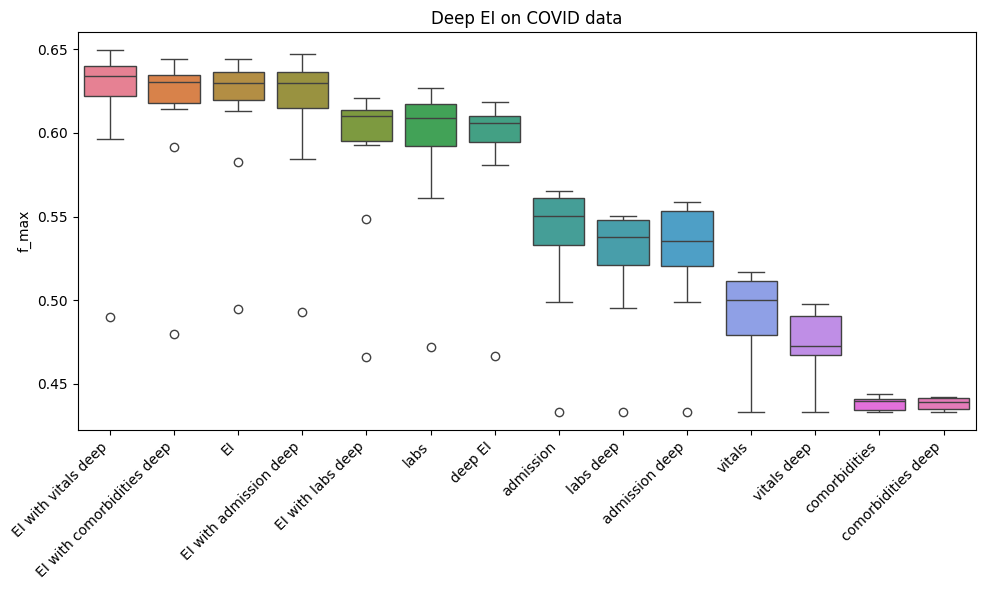

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example dictionary with DataFrames
data_dict = performance_metrics

# Specify the row index for which you want to generate the boxplot
row_index = 'f_max'

# Create a list to store the data for the boxplot
data_list = []

# Iterate through the dictionary keys and extract the row data
for key, df in data_dict.items():
    if row_index in df.index:
        data_list.append(df.loc[row_index].values)

# Create a DataFrame for Seaborn
data_df = pd.DataFrame(data_list, index=data_dict.keys(), columns=df.columns)
# Box and Whiskers Plot using Seaborn
box_order = data_df.median(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df.T[box_order])
plt.title("Deep EI on COVID data")
plt.ylabel(row_index)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
data_df

,Mean,CES,S.ADAB,S.XGB,S.DT,S.RF,S.GB,S.KNN,S.LR,S.NB,S.MLP,S.SVM
admission,0.560352,0.555930,0.547589,0.518040,0.433344,0.537870,0.553556,0.498805,0.565269,0.565517,0.562311,0.544299
admission deep,0.533057,0.528471,0.551812,0.516657,0.433344,0.521717,0.553976,0.499220,0.557491,0.552803,0.558536,0.538204
EI with admission deep,0.617490,0.638703,0.616227,0.610159,0.492710,0.628873,0.639156,0.584284,0.646914,0.633057,0.635556,0.630637
comorbidities,0.443906,0.440304,0.439716,0.434681,0.433344,0.439519,0.440042,0.433344,0.444172,0.440584,0.441477,0.433372
comorbidities deep,0.441581,0.441962,0.438466,0.435294,0.433344,0.435249,0.439493,0.433344,0.441384,0.442284,0.441300,0.433486
EI with comorbidities deep,0.630415,0.644091,0.619048,0.614504,0.479910,0.634084,0.635800,0.591412,0.639679,0.633202,0.630579,0.630487
labs,0.601408,0.622404,0.608857,0.560843,0.472077,0.602240,0.615385,0.564248,0.626816,0.614815,0.621860,0.608403
labs deep,0.528818,0.540845,0.548252,0.522005,0.433344,0.534328,0.550103,0.495620,0.547808,0.544202,0.549209,0.517877
EI with labs deep,0.592477,0.611695,0.596309,0.607979,0.466188,0.613007,0.620781,0.548553,0.617185,0.601610,0.615055,0.611833
vitals,0.516584,0.511901,0.498753,0.471483,0.433344,0.485272,0.501759,0.455110,0.511246,0.512488,0.501977,0.481565


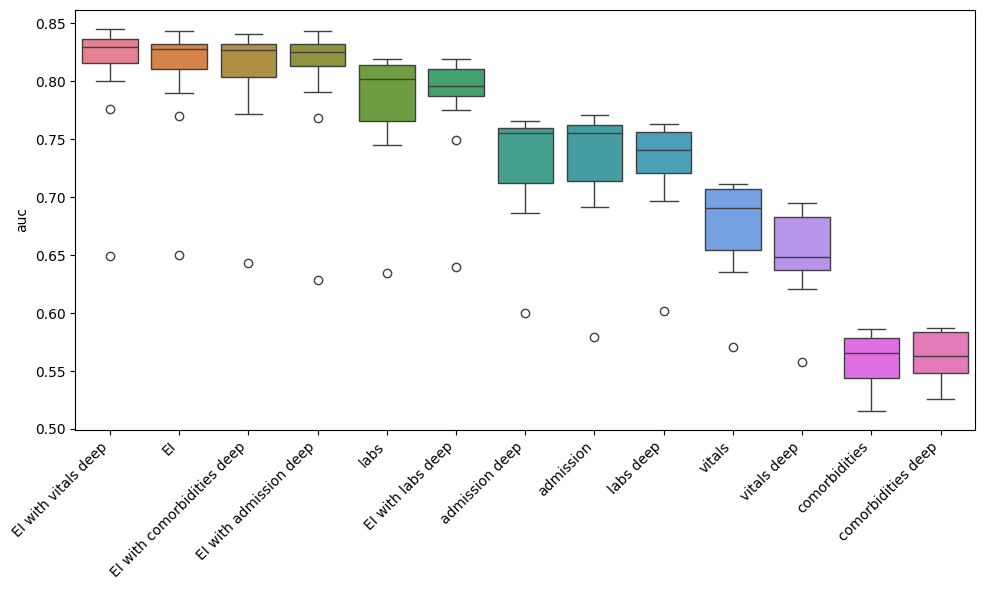

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example dictionary with DataFrames
data_dict = performance_metrics

# Specify the row index for which you want to generate the boxplot
row_index = 'auc'

# Create a list to store the data for the boxplot
data_list = []

# Iterate through the dictionary keys and extract the row data
for key, df in data_dict.items():
    if row_index in df.index:
        data_list.append(df.loc[row_index].values)

# Create a DataFrame for Seaborn
data_df = pd.DataFrame(data_list, index=data_dict.keys(), columns=df.columns)
# Box and Whiskers Plot using Seaborn
box_order = data_df.median(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df.T[box_order])
plt.ylabel(row_index)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
data_df

,Mean,CES,S.ADAB,S.XGB,S.DT,S.RF,S.GB,S.KNN,S.LR,S.NB,S.MLP,S.SVM
admission,0.761031,0.756862,0.753303,0.720673,0.579215,0.742814,0.757926,0.694064,0.771042,0.767125,0.768544,0.691569
admission deep,0.758686,0.756817,0.757589,0.718621,0.600080,0.727212,0.753798,0.692039,0.765665,0.763349,0.765115,0.686143
EI with admission deep,0.820425,0.831318,0.820023,0.821231,0.628347,0.833407,0.836920,0.768504,0.842949,0.829779,0.831289,0.791135
comorbidities,0.574928,0.578629,0.560100,0.545048,0.520165,0.564757,0.566738,0.515650,0.586549,0.579131,0.580880,0.540861
comorbidities deep,0.586698,0.585158,0.559046,0.550285,0.543325,0.553722,0.567415,0.539949,0.582112,0.586073,0.582955,0.525751
EI with comorbidities deep,0.828858,0.833790,0.815168,0.809345,0.643609,0.830391,0.832511,0.772042,0.840393,0.832534,0.824633,0.786573
labs,0.800824,0.814680,0.800297,0.772254,0.634260,0.802590,0.813261,0.745175,0.818885,0.808592,0.815694,0.745408
labs deep,0.727711,0.738029,0.754873,0.731089,0.601849,0.743190,0.759917,0.699607,0.761392,0.746572,0.762766,0.696607
EI with labs deep,0.793817,0.792709,0.791026,0.798665,0.639818,0.809430,0.814431,0.749557,0.819380,0.803626,0.814590,0.774809
vitals,0.707028,0.701276,0.689987,0.658910,0.570378,0.678990,0.691548,0.640203,0.711458,0.710038,0.707073,0.635415


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data
data_fmax = {
    'admission': [0.5734265734265734, 0.5701078582434514, 0.5415617128463476, 0.5586776859504131, 0.580829756795422, 0.5531914893617021, 0.5505804311774462, 0.5929078014184397, 0.5783132530120483, 0.5763239875389408],
    'comorbidities': [0.4399293286219082, 0.44616709732988796, 0.45276292335115864, 0.4488330341113105, 0.448, 0.44665461121157324, 0.4446381865736704, 0.43453237410071943, 0.43996494303242767, 0.44786324786324794],
    'labs': [0.5371577574967406, 0.5903083700440529, 0.549237170596394, 0.4994663820704375, 0.5819209039548023, 0.5451851851851852, 0.5533834586466165, 0.5690140845070423, 0.56071964017991, 0.5757575757575758],
    'vitals': [0.5413333333333333, 0.5199306759098786, 0.5006016847172082, 0.5241157556270095, 0.5346534653465347, 0.5163120567375886, 0.5050215208034433, 0.5008130081300812, 0.5333333333333333, 0.5103857566765578],
    'EI': [0.623946037099494, 0.6388384754990926, 0.5924812030075187, 0.5745454545454546, 0.6459802538787024, 0.6376811594202898, 0.5988857938718662, 0.6324503311258278, 0.6088235294117648, 0.6319218241042345]
}

# Create a DataFrame from the data
df_fmax = pd.DataFrame(data_fmax)

# Melt the DataFrame to have 'variable' and 'value' columns
melted_df_fmax = pd.melt(df_fmax, var_name='Box', value_name='fmax')

# Order boxes by median value in descending order
box_order_fmax = melted_df_fmax.groupby('Box')['fmax'].median().sort_values(ascending=False).index

# Box and Whiskers Plot using Seaborn with sorted order
plt.figure(figsize=(10, 6))
sns.boxplot(x='Box', y='fmax', data=melted_df_fmax, order=box_order_fmax)
plt.title('fmax')
plt.ylabel('fmax values')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# New Data
data_auc = {
    'admission': [0.7693368960628204, 0.7763605627658414, 0.7450430799432872, 0.7462754935107427, 0.770792889082779, 0.7577980150507143, 0.7505071436361654, 0.7867052023121386, 0.7761533427854729, 0.7670302104918748],
    'comorbidities': [0.5858681426545971, 0.6006898244083324, 0.5892790925946121, 0.6054913294797688, 0.6006434725706183, 0.6028792670956483, 0.5933962264150944, 0.5791389464499945, 0.5988330243210818, 0.5883438761042643],
    'labs': [0.745435707274512, 0.7772576071545426, 0.7408386956047552, 0.6439551750463519, 0.7786563420220307, 0.7274511942414658, 0.729921474533755, 0.7614570836514343, 0.7573890282473552, 0.790827789289999],
    'vitals': [0.723301341476715, 0.7141073181372014, 0.6892736394372342, 0.7114570836514342, 0.7110917221071, 0.7164358163376594, 0.6920111244410514, 0.6925019086050823, 0.7171011015377903, 0.7009870214854401],
    'EI': [0.8165612389573564, 0.8320809248554913, 0.7991220416621223, 0.7975079070781983, 0.8307449012978515, 0.8131911876976771, 0.8019413240266113, 0.8284109499400153, 0.8158905005998474, 0.8327952884720253]
}

# Create a DataFrame from the new data
df_auc = pd.DataFrame(data_auc)

# Melt the DataFrame to have 'variable' and 'value' columns
melted_df_auc = pd.melt(df_auc, var_name='Box', value_name='auc')

# Order boxes by median value in descending order
box_order = melted_df_auc.groupby('Box')['auc'].median().sort_values(ascending=False).index

# Box and Whiskers Plot using Seaborn with sorted order
plt.figure(figsize=(10, 6))
sns.boxplot(x='Box', y='auc', data=melted_df_auc, order=box_order)
plt.title('EI vs modalities')
plt.ylabel('AUC')
plt.show()

In [ ]:
EI = e.EnsembleIntegration(
                        k_outer=5,
                        k_inner=5,
                        n_samples=1,
                        sampling_strategy="undersampling",
                        sampling_aggregation=None,
                        n_jobs=-1,
                        metrics=metrics,
                        random_state=38,
                        project_name="diabetes",
                        model_building=True,
                        )

In [ ]:
for k,v in X_train.items():
    if k == "xgboost":
        EI.fit_base(v, y_train, modality_name=k, base_predictors=d_base_predictors)
    else:
        EI.fit_base(v, y_train, modality_name=k, base_predictors=base_predictors)

In [ ]:
EI.base_summary["metrics"]

In [ ]:
EI.fit_ensemble(ensemble_predictors=ensemble_predictors)

In [ ]:
EI.ensemble_summary["metrics"]

In [ ]:
preferred_ensemble_key = EI.ensemble_summary["metrics"].loc["auc"].idxmax()
print(preferred_ensemble_key)
y_pred = EI.predict(X_dict=X_test, ensemble_model_key=preferred_ensemble_key)
roc_auc_score(y_test, y_pred)

interpreter

In [ ]:
from eipy.interpretation import PermutationInterpreter

interpreter = PermutationInterpreter(EI=EI,
                                     metric=lambda y_test, y_pred: roc_auc_score(y_test, y_pred),
                                     ensemble_predictor_keys=preferred_ensemble_key,
                                     n_jobs=-1)

In [ ]:
EI.ensemble_predictors.keys()

In [ ]:
interpreter.rank_product_score(X_dict=X_test, y=y_test)